# Data generation demonstration

## Imports

In [34]:
import numpy as np
from numba.typed import List, Dict
import scipy as sc
import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import pathlib

import src.data_generation as dg
from src.data_generation import generate_dataset, symmetrical_colormap
from src.data_loaders import Importer

%reload_ext autoreload
%autoreload 2
%aimport src.data_generation

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

## Walkthrough

Below we'll walk through the generation of a single sample from disorderless training dataset. Let us take an examle close to the fully dimerized limit $(v = 0 + \epsilon)$

Let's define a save location for the dataset

In [15]:
save_loc = pathlib.Path("./00_demonstrations_data/datasets").joinpath(f"disorderless_training_data")
save_loc.mkdir(exist_ok=True, parents=True)

SSH model variables

In [16]:
# Intercell hopping
ww = 1
# Intracell hopping
vv = 0.01
# Hopping amplitude
J = 1
# Number of sites
M = 50
# Disorder strength
W = 0
# N - Number of particles in a system
N = np.array([1])

# Statistic (bose/fermi)
stat_vec = np.array(["f"])
component_count = len(stat_vec)


# Dataset designation
which_dataset = 'training'
# Number of samples (Usually O(10^3))
nsamples = 100

Each dataset is generated for $v/w \in (0, 2)$.   
For the training and validation datasets we exclude the data fron the vincinity of the phase transition ($v/w \in (0.8, 1.2)$).

In [17]:
# =============================================================================
# Split range for the validation and training datasets
# =============================================================================

# Training dataset values
if which_dataset == 'training':
    vv_tab = np.append(np.linspace(0, 0.8, nsamples//2), np.linspace(1.2, 2, nsamples//2))

# Validation dataset values
elif which_dataset == 'validation':
    vv_tab = np.append(np.linspace(0.001, 0.801, nsamples//2), np.linspace(1.201, 2.001, nsamples//2))

# Test dataset values
elif which_dataset == 'test':
    vv_tab = np.linspace(0.002, 2.002, nsamples)

else:
    raise ValueError("Incorrect dataset type")

if which_dataset != 'test':
    dataset_designation = which_dataset
else:
    dataset_designation = f"{which_dataset}_{counter_start+real_num}"

First, we calculate the winding number for the given v, using periodic boundary conditions (PBC). Then we calculate the same system assuming open boundary conditions. The edge states, which we want to investigate, only appear in a system with open boundary conditions (OBC)

**Part responsible for calculating the winding number for the system**

Generation of the Fock basis needed for ED

In [18]:
# Staggering tab - SSH parameter
vw_tab = np.array([vv, ww])

# Disorder Measure - W_1, W_2
W_disorder_tab = np.array([0.5 * W, W])

# D - Dimension of the final Hamiltonian matrix
D = dg.calc_dim_tab(M, N, stat_tab=stat_vec)

# Getting the full Fock basis
A = dg.get_tensor_basis(
    M, N, statistic=stat_vec, component_count=component_count, verb=0
)

# Getting the basis vectors hashed
tab_T = np.array([dg.tag_func(v) for v in A])

# Preserving the original order of basis vectors
ind = np.argsort(tab_T)

# Sorting the new array for more efficient searching (by bisection)
t_sorted = tab_T.copy()
t_sorted.sort()
t_dict = Dict()

for key, val in zip(tab_T, np.arange(0, A.shape[0])):
    t_dict[key] = val

Generation of the Hamiltonians (in PBC and OBC)

In [19]:
# For winding number calculation we use periodic bounary conditions (PBC)
# Initialization of lists for Hamiltonian matrices

H_hop_pbc = [List(), List(), List()]
H_hop_obc = [List(), List(), List()]

# Getting the Hamiltonian matrices
"""
We will calculate the Hamiltonian for both PBC and OBC.
This way we have exactly the same system, the same random numbers,
the same tunneling amplitudes, but different boundary conditions.
"""
H_hop_pbc, H_hop_obc = dg.get_kinetic_H_vw_both(
    A,
    M,
    J,
    t_dict,
    vw=vw_tab,
    disord_W=W_disorder_tab,
    statistic=stat_vec[0],
    component_count=component_count,
    component_no=0,
)

# Converting the Hamiltonian to sparse format
# PBC
H_hop_pbc = sc.sparse.coo_matrix(
    (H_hop_pbc[0], (H_hop_pbc[1], H_hop_pbc[2])), shape=(D, D)
)

H_hop_pbc = sc.sparse.triu(H_hop_pbc)

H_hop_pbc = (
    H_hop_pbc
    + H_hop_pbc.T
    - sc.sparse.diags(H_hop_pbc.diagonal(), format="coo")
)

H_dense_pbc = (J * H_hop_pbc).toarray()

Calculation of the winding number. It is explained in detail in [this jupyter notebook](./05_explain_windnum.ipynb)

In [20]:
dvec = np.array(
    [
        (lambda snum: 1 if snum % 2 == 0 else -1)(snum)
        for snum in range(M)
    ]
)

chiral = sc.sparse.coo_matrix(sc.sparse.diags(dvec))

ch_evals, ch_evecs = np.linalg.eigh(chiral.toarray())

sorted_evecs = np.zeros(shape=(D, D))
sorted_evals = np.zeros(shape=(D,))

for num, i in enumerate(
    np.repeat(
        np.linspace(0, D // 2, D // 2, endpoint=False, dtype=np.int64),
        2,
    )
):
    rownum = np.where(ch_evecs[:, -(num + 1)] == 1)[0][0]
    fact = 0 if num % 2 == 0 else int(D / 2)
    new_rownum = fact + i
    new_row = ch_evecs[rownum].copy()
    sorted_evecs[new_rownum] = new_row
    sorted_evals[new_rownum] = ch_evals[rownum].copy()

ch_evecs = sorted_evecs
ch_evals = sorted_evals

H_new_basis = ch_evecs @ H_dense_pbc @ (np.linalg.inv(ch_evecs))

u = H_new_basis[D // 2 :, : D // 2]

v, w, k = sp.symbols("v w k", real=True)

u = sp.Matrix(u)

u[-1, 0] = u[-1, 0] * sp.exp(sp.I * k)

dkh = sp.simplify(sp.Derivative(u, k).doit())

hinv = sp.Inverse(u).doit()

h1_fin = hinv @ dkh

expr1 = sp.Trace(h1_fin).doit() / (2 * sp.pi * sp.I)

integrand1 = sp.lambdify(k, expr1.doit(), "scipy")

r1, r1err = sc.integrate.quad(
    integrand1, -np.pi, np.pi - np.finfo(float).eps
)

winding_number = r1
print(f"Winding number for the system is: {winding_number:.0f}")

del r1, r1err, hinv, h1_fin, expr1, integrand1, u, H_new_basis, H_dense_pbc, H_hop_pbc

Winding number for the system is: 1


/Users/k4cp3rskiii/miniforge3/envs/ML_Pytorch/lib/python3.8/site-packages/scipy/integrate/quadpack.py:463: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


**Part responsible for calculating the eigenvectors observables we will supply to the the CNN**

In [21]:
# Now we switch to open bounary conditions (OBC)

# Converting the Hamiltonian to sparse format
# OBC
H_hop_obc = sc.sparse.coo_matrix(
    (H_hop_obc[0], (H_hop_obc[1], H_hop_obc[2])), shape=(D, D)
)

H_hop_obc = sc.sparse.triu(H_hop_obc)

H_hop_obc = (
    H_hop_obc
    + H_hop_obc.T
    - sc.sparse.diags(H_hop_obc.diagonal(), format="coo")
)

H_obc = J * H_hop_obc

H_tot_obc = H_obc

H_dense_obc = H_tot_obc.toarray()

evals_obc, evecs_obc = np.linalg.eigh(H_dense_obc)

observable = evecs_obc**2

Let's have a look at the data sample

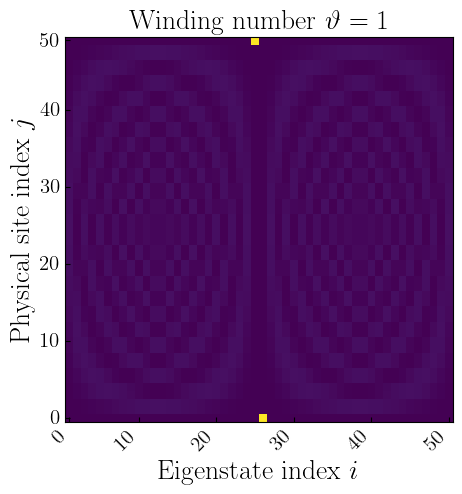

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ticksize = 15
fontsize = 20

ax.imshow(observable, aspect="auto")
ax.set_xticks([0, 9, 19, 29, 39, 49], size=ticksize)
ax.set_xticklabels([0, 10, 20, 30, 40, 50], size=ticksize, rotation=45, ha="right")

ax.set_yticks([0, 9, 19, 29, 39, 49][::-1], size=ticksize)
ax.set_yticklabels([0, 10, 20, 30, 40, 50], size=ticksize, rotation=0, ha="right", va="center")

ax.set_xlabel("Eigenstate index $i$", size=fontsize)
ax.set_ylabel("Physical site index $j$", size=fontsize)

ax.tick_params(axis='both', which='both', direction='in')

ax.set_title("Winding number "+r"$\vartheta = {}$".format(int(round(winding_number, 0))), size=fontsize);

## Automated generation

This whole process is also packaged as a single function

In [23]:
dset_generation_params = {
    'nsamples': nsamples,
    'which_dataset': which_dataset,
    'M': M,
    'J': J,
    'w_ssh': ww,
    'override_save_loc': save_loc,
    # This code function can also be used to generate the disordered datasets
    'W': W, # Disorder strength
    'real_num': 0, # This is the disorder realization number
    'n_reals_tot': 25, # This is the total number of disorder realizations
}

In [ ]:
generate_dataset(**dset_generation_params)

## Recreation of Fig. 3
**Fidelity plot**

Once we generate the datasets, we can investigate the possible spurious correlations in it. One type of them we were able to identify was the fidelity of any given eigenstate $e_i$ at $v=0$ and at $v\neq 0$. (Fig.3 in manuscript).

To plot these correlations you need to either generate yourself a pair of disorderless and disordered datasets, or download them from Zenodo

Let's define here the paths for loading the datasets, and saving the generated figure

Saving

In [24]:
plots_save_path = pathlib.Path("./00_demonstrations_data/figures/")
png_save_path = plots_save_path.joinpath("PNG/")
plots_save_path.mkdir(exist_ok=True, parents=True)
png_save_path.mkdir(exist_ok=True, parents=True)

Loading

In [25]:
load_path = pathlib.Path("./00_demonstrations_data/datasets")
disorderless_ds_path = load_path.joinpath("disorderless")
disordered_ds_path = load_path.joinpath("disordered_W=0.15")

Calculation constants

In [26]:
class_names = ["Trivial", "Topological"]
def_batch_size = -1
M = 50
initial_ind = 0

Disorderless system calculation

In [27]:
disorderless_ds = Importer(disorderless_ds_path, def_batch_size)

disorderless_test_loader = disorderless_ds.get_test_loader()
disorderless_X = disorderless_test_loader.dataset.X.numpy()
disorderless_Y = disorderless_test_loader.dataset.Y.numpy()
disorderless_V = np.linspace(0.002, 2.002, 500)

In [28]:
disorderless_norms = []
disorderless_v_tab = []
disorderless_state_ind = []
for state_ind in range(0, M):
    for v_ind, v in enumerate(disorderless_V):
        disorderless_norms.append(np.dot(np.sqrt(disorderless_X[initial_ind, 0, :, state_ind]), np.sqrt(disorderless_X[v_ind, 0,  :, state_ind]).T))
        disorderless_v_tab.append(v)
        disorderless_state_ind.append(state_ind)

disorderless_df = pd.DataFrame({"norm": disorderless_norms, "v": disorderless_v_tab, "state_ind" : disorderless_state_ind})

Disordered system calculation

In [29]:
disordered_ds = Importer(disordered_ds_path, def_batch_size)
disordered_test_loader = disordered_ds.get_test_loader()
disordered_X = disordered_test_loader.dataset.X.numpy()
disordered_Y = disordered_test_loader.dataset.Y.numpy()
disordered_V = np.linspace(0.002, 2.002, 500)

In [30]:
disordered_norms = []
disordered_v_tab = []
disordered_state_ind = []
for state_ind in range(0, M):
    for v_ind, v in enumerate(disordered_V):
        disordered_norms.append(np.dot(np.sqrt(disordered_X[initial_ind, 0, :, state_ind]), np.sqrt(disordered_X[v_ind, 0, :, state_ind]).T))
        disordered_v_tab.append(v)
        disordered_state_ind.append(state_ind)

disordered_df = pd.DataFrame({"norm": disordered_norms, "v": disordered_v_tab, "state_ind" : disordered_state_ind})

Definition of a symmetrical colormap (To highlight the edge states and their vicinity)

In [31]:
# Creating a symmetrical colormap for the plots
cmap = plt.cm.get_cmap('cividis')
cmap_settings = ('cividis', None)  # provide int instead of None to "discretize/bin" the colormap
new_cmap = symmetrical_colormap(cmap_settings=cmap_settings, new_name ='SymCividis')
colors = np.concatenate([cmap(np.linspace(0, 1, 25))[::-1], cmap(np.linspace(0, 1, 25))])

# Tworzenie obiektu ScalarMappable
norm = Normalize(vmin=min(disorderless_df["state_ind"].unique()), vmax=max(disorderless_df["state_ind"].unique()))
sm = ScalarMappable(cmap=new_cmap, norm=norm)
sm.set_array([])

Plotting

This plot often throws a $\LaTeX$-related error on first run, it disappears on rerun.

In [38]:
plots_save_path = pathlib.Path("./00_demonstrations_data/figures/")
png_save_path = plots_save_path.joinpath("PNG/")


plots_save_path.mkdir(exist_ok=True, parents=True)
png_save_path.mkdir(exist_ok=True, parents=True)

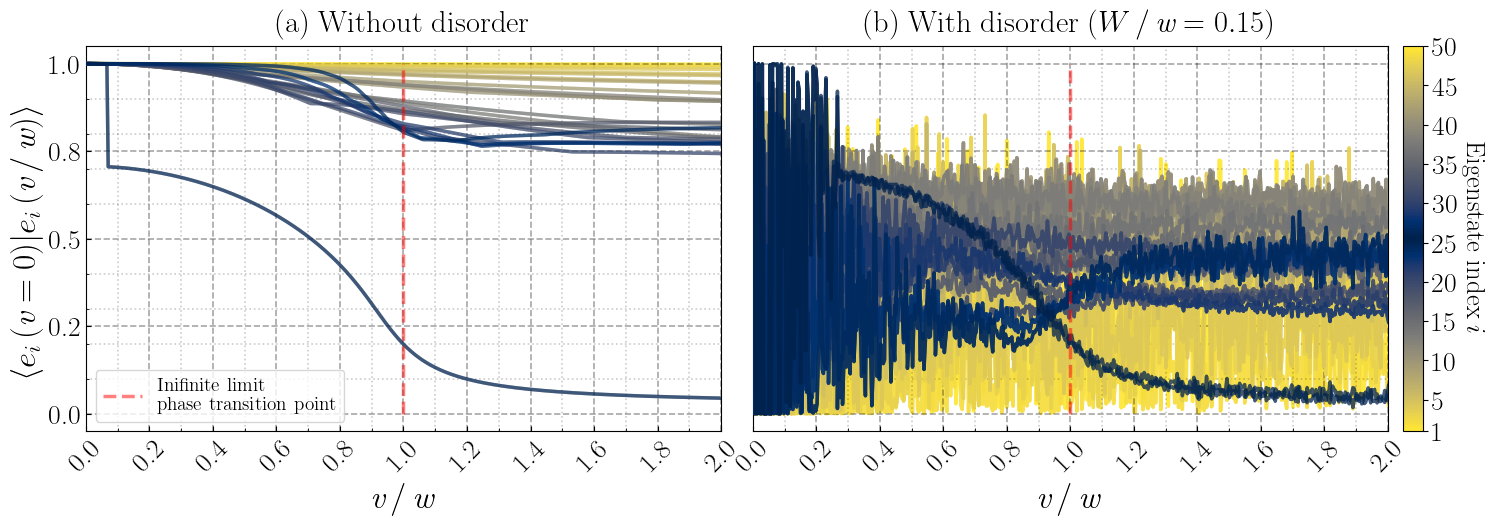

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(20, 5), sharey=True)

# Toggle use of latex serif font
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontsize = 24
ticksize = 20
titlesize = 22
ticks_num = 5
lw = 2.5

# Reduce horizontal space
plt.subplots_adjust(wspace=0.05)

ax = axs[0]

order = np.concatenate([np.arange(0, 25, 1), np.arange(24, -1, -1)])
for state_ind in disorderless_df["state_ind"].unique():
    ax.plot(disorderless_df[disorderless_df["state_ind"] == state_ind]["v"], disorderless_df[disorderless_df["state_ind"] == state_ind]["norm"], lw=lw, alpha=0.5, color=colors[state_ind], zorder=order[state_ind])

ax.set_title("(a) Without disorder", size=titlesize, pad=10)
ax.set_ylabel(r"$ \langle e_i\,(\textit{v} = 0) | e_i\,(\textit{v}\,/\,\textit{w}) \rangle  $", size=fontsize)

ax = axs[1]

for state_ind in disordered_df["state_ind"].unique():
    ax.plot(disordered_df[disordered_df["state_ind"] == state_ind]["v"], disordered_df[disordered_df["state_ind"] == state_ind]["norm"], lw=lw, alpha=0.75, color=colors[state_ind], zorder=order[state_ind])

ax.set_title(r"(b) With disorder ($W \,/\,\textit{w} = 0.15$)", size=titlesize, pad=10)

for ax in axs.flatten():
    ytick_pos = np.linspace(0, 1, ticks_num)
    xtick_pos = np.linspace(0, 2, 11)
    # Create major and minor locators for x and y axes
    ax.xaxis.set_major_locator(plt.FixedLocator(xtick_pos))
    ax.xaxis.set_minor_locator(plt.FixedLocator(np.linspace(0, 2, 21)))
    ax.yaxis.set_major_locator(plt.FixedLocator(ytick_pos))
    ax.yaxis.set_minor_locator(plt.FixedLocator(np.linspace(0, 1, 11)))

    # Set grid
    ax.grid(which='major', linestyle='--', linewidth='1.2', color='black', alpha=0.35)
    ax.grid(which='minor', linestyle=':', linewidth='1.2', color='black', alpha=0.2)
    # ax.set_title("Predictions", size=fontsize)
    ax.set_xticks(xtick_pos)
    ax.set_yticks(ytick_pos)
    ax.set_yticklabels([f"{t:.1f}" for t in np.linspace(0, 1, ticks_num)], size=ticksize, rotation=0, ha="right")
    ax.set_xticklabels([f"{t:.1f}" for t in np.linspace(0, 2, 11)], size=ticksize, rotation=45, ha="center")
    ax.set_xlabel(r"$\textit{v}\,/\,\textit{w}$", size=fontsize)
    ax.tick_params(axis='both', which='both', direction='in')

    ax.set_xlim(0, 2)

    ax.vlines(1, 0, 1, color='red', linestyles='dashed', lw=2.5, alpha=0.5, label='Inifinite limit\nphase transition point', zorder=100)

cbar = plt.colorbar(sm, ax=axs, orientation='vertical', pad=0.01)
cbar.set_label('Eigenstate index $i$', rotation=270, labelpad=20, size=0.8*fontsize)
cbar.set_ticks([0, 4, 9, 14, 19, 24, 29, 34, 39, 44, 49])
cbar.set_ticklabels([1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], size=ticksize)
axs[0].legend(fontsize=0.575*fontsize)

# Add the legend below both plots, and make it horizontal
# fig.legend(title="Eigenstate #", fancybox=True, shadow=True, fontsize=22, loc='center', bbox_to_anchor=(0.5, -0.1), title_fontsize=30, ncol=14)

fig.savefig(plots_save_path.joinpath("Fig_3.pdf"), bbox_inches='tight')
fig.savefig(png_save_path.joinpath("Fig_3.png"), bbox_inches='tight')